In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from binance_utils import *
import statsmodels.api as sm
from keras.models import load_model

# from sklearnex import patch_sklearn
# patch_sklearn()

In [134]:
# Cargar datos:
df = pd.read_parquet('datasets/merged_data.parquet')

# Establecer 'timestamp' como índice:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Análisis Exploratorio de Datos

## Validación de datos

In [135]:
# Calcular las diferencias en segundos
time_diff_seconds = df.index.to_series().diff().dt.total_seconds()

# Calcular la media de las diferencias
time_mean_diff_seconds = time_diff_seconds.mean()
print("Frecuencia entre observaciones, en segundos: ", time_mean_diff_seconds)

Frecuencia entre observaciones, en segundos:  0.5032822274653643


In [136]:
# Revisamos valores nulos:
null_values = df.isnull().sum()
columns_with_nulls = null_values[null_values > 0]

if not columns_with_nulls.empty:
    print(columns_with_nulls)
else:
    print("No hay valores nulos en el DataFrame.")

No hay valores nulos en el DataFrame.


In [137]:
# # Revisamos filas duplicadas:
# duplicated_rows = df.duplicated().sum()

# if duplicated_rows > 0:
#     duplicated_pct = duplicated_rows / len(df)
#     print(f"Porcentaje de observaciones duplicadas: {duplicated_pct:.2%}")
# else:
#     print("No hay observaciones duplicadas en el DataFrame.")

In [138]:
# Validar consistencia de 'timestamp':
time_diff = df.index.to_series().diff().value_counts()
print(time_diff)

timestamp
0 days 00:00:00.500000768    406877
0 days 00:00:00.500001024    386927
0 days 00:00:00.500001280    375101
0 days 00:00:00.500001536    333432
0 days 00:00:00.500002048    310141
0 days 00:00:00.500000512    244268
0 days 00:00:00.500001792    222360
0 days 00:00:00.500002304    180051
0 days 00:00:00.500002816     99929
0 days 00:00:00.500000256     79793
0 days 00:00:00.500002560     63101
0 days 00:00:00.500003072     32115
0 days 00:00:00.500000         9791
0 days 00:00:00.500003328      1674
0 days 00:10:00.919105024         1
0 days 00:10:00.694799616         1
0 days 00:10:00.684328448         1
0 days 00:10:00.645758208         1
0 days 00:10:02.370601728         1
0 days 00:10:01.053577728         1
0 days 00:10:00.838393856         1
0 days 00:10:00.735068928         1
0 days 00:10:01.408174336         1
0 days 00:10:00.803035904         1
0 days 00:10:00.872205568         1
0 days 00:10:00.729733376         1
0 days 00:10:01.093585664         1
0 days 00:10:01.14

En `time_diff` también se observan saltos temporales atípicos de 10 minutos. Investigamos su naturaleza.

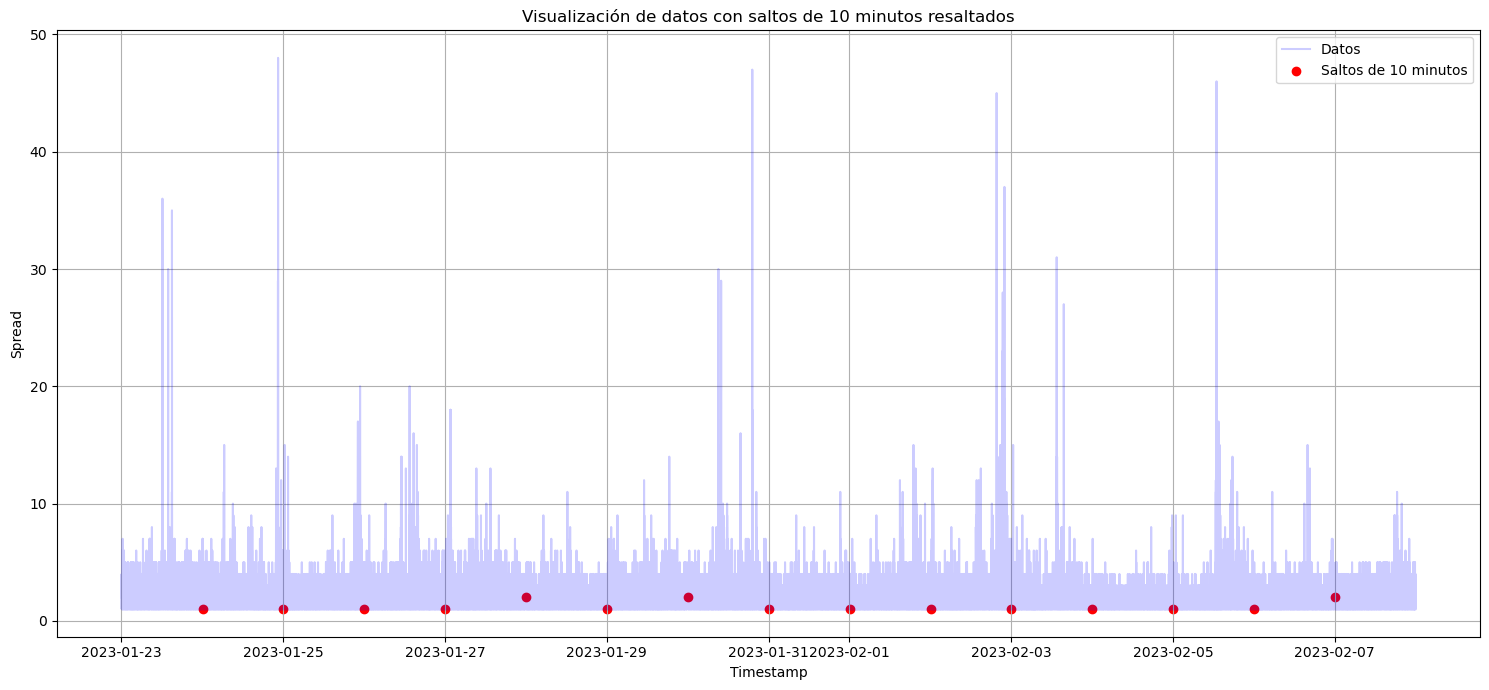

In [139]:
# Asegurarse de que los datos estén ordenados por timestamp:
df_10min = df.reset_index().sort_values(by='timestamp')

# Calcular la diferencia entre timestamps consecutivos:
df_10min['time_diff'] = df_10min['timestamp'].diff()

# Identificar los puntos de interés:
mask = df_10min['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Graficar los datos:
plt.figure(figsize=(15, 7))
plt.plot(df_10min['timestamp'], df_10min['spread'], label='Datos', color='blue', alpha=0.2)
plt.scatter(df_10min[mask]['timestamp'], df_10min[mask]['spread'], color='red', label='Saltos de 10 minutos')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.title('Visualización de datos con saltos de 10 minutos resaltados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
# Calcular la diferencia entre timestamps consecutivos:
df_10min['time_diff'] = df_10min['timestamp'].diff()

# Identificar los puntos de interés:
mask = df_10min['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Crear una máscara para los puntos inmediatamente posteriores:
next_mask = mask.shift(-1, fill_value=False)

# Combinar las dos máscaras usando el operador "or":
combined_mask = mask | next_mask

# Extraer estos puntos en un nuevo DataFrame:
df_10min_timeskips = df_10min[combined_mask].copy()

df_10min_timeskips.sort_values('timestamp', ascending=True, inplace=True)
df_10min_timeskips.set_index('timestamp', inplace=True)

print("Saltos de 10 minutos detectados:\n", df_10min_timeskips.index)


Saltos de 10 minutos detectados:
 DatetimeIndex(['2023-01-23 23:54:59.459493120',
               '2023-01-24 00:05:00.602287104',
               '2023-01-24 23:54:59.469715200',
               '2023-01-25 00:05:00.563300864',
               '2023-01-25 23:54:59.934701568',
               '2023-01-26 00:05:00.664434944',
               '2023-01-26 23:54:59.788566016',
               '2023-01-27 00:05:00.626959872',
               '2023-01-27 23:54:59.901041408',
               '2023-01-28 00:05:00.773246976',
               '2023-01-28 23:54:59.843753472',
               '2023-01-29 00:05:00.646789376',
               '2023-01-29 23:54:59.372211712',
               '2023-01-30 00:05:00.780386048',
               '2023-01-30 23:54:59.890614528',
               '2023-01-31 00:05:00.625683456',
               '2023-01-31 23:54:59.606319360',
               '2023-02-01 00:05:00.659897088',
               '2023-02-01 23:54:58.416104192',
               '2023-02-02 00:05:00.786705920',
      

Los saltos temporales de 10 minutos ocurren cada vez entre las `23:55:00` y las `00:05:00`. Esto puede tratarse a cierres temporales programados en el sistema de recolección de datos.

### Eliminación de valores atípicos

En este enfoque, consideramos la no eliminación de valores atípicos, pues su presencia garantiza una granularidad media de 0.5 segundos, lo cual es deseado para el entrenamiento de la red LSTM.

Dado que estamos trabajando con una red LSTM para predicciones de series temporales, la consistencia y granularidad de los datos son cruciales. Las LSTMs son sensibles a la secuencia y orden de los datos. Si la eliminación de outliers causa brechas significativas en tus datos, podría ser beneficioso mantenerlos, especialmente si los outliers representan eventos reales.

Sin embargo, al decidir mantener los outliers, es importante tener en cuenta cómo el modelo responde a ellos durante el entrenamiento y validación. Podríamos considerar técnicas como la regularización para evitar el sobreajuste.

Una estrategia intermedia podría ser no eliminar completamente los outliers, sino más bien suavizarlos o ajustarlos a un valor menos extremo, preservando así la granularidad de los datos mientras reducimos el impacto del ruido.

### Visualizaciones

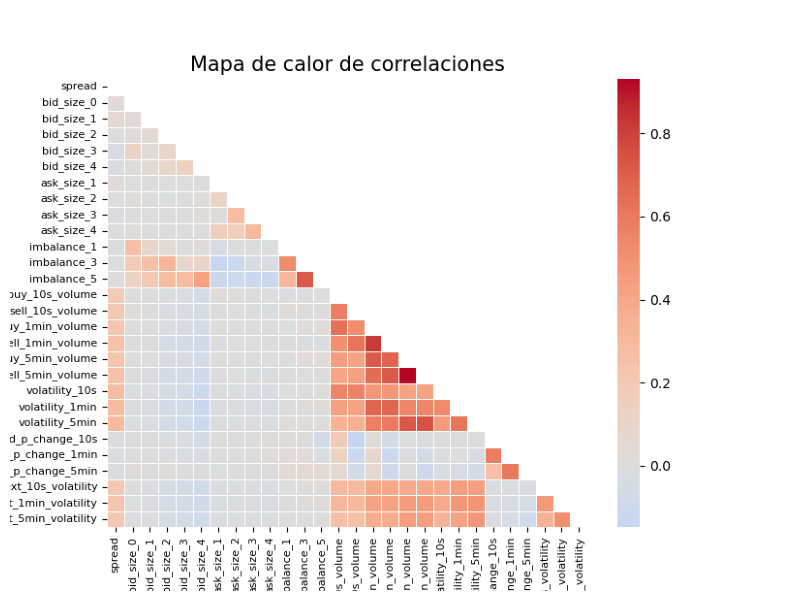

In [141]:
# # Mapa de calor
# corr = df.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
# plt.figure(figsize=(8, 6))
# sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=False)
# plt.title('Mapa de calor de correlaciones', size=15)
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.savefig('images/heatmap_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/heatmap_all_outs.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

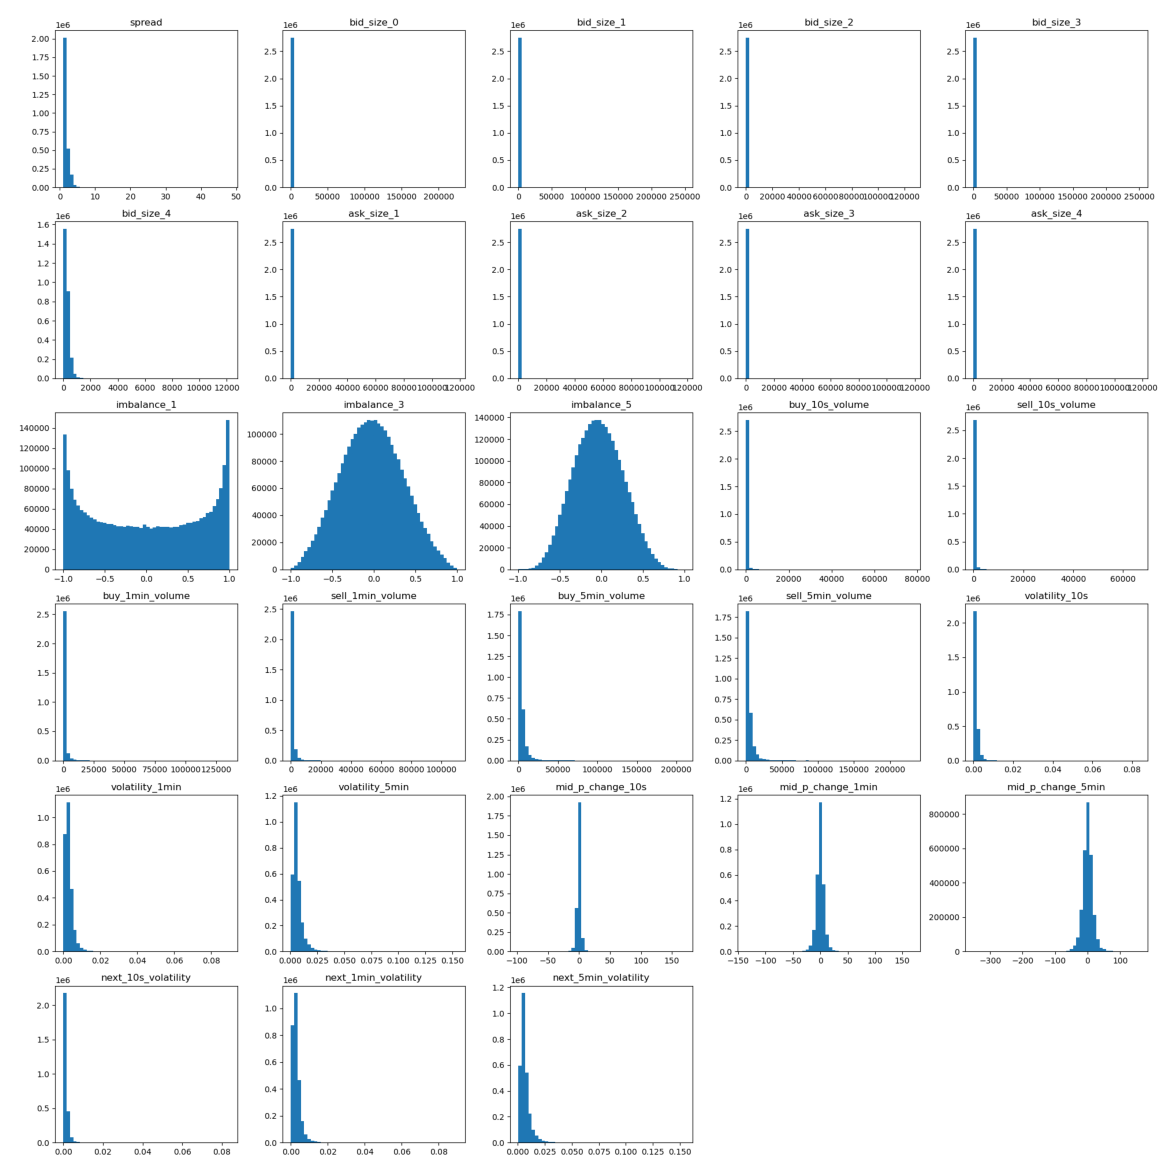

In [142]:
# # Plotear histogramas de cada variable:
# df.hist(figsize=(20, 20), bins=50, grid=False)
# plt.tight_layout()
# plt.savefig('images/hists_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/hists_all_outs.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis('off')
plt.show()

Notamos una distribución extraña de la variable objetivo, `mid_p_change_10s`. Efectuamos algunos tests estadísticos para chequear su normalidad, sesgo y curtosis.

In [143]:
import scipy.stats as stats

Y = df[target_var]

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(Y)
print(f"Shapiro-Wilk Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Kurtosis y Asimetría
kurtosis_val = stats.kurtosis(Y)
skewness_val = stats.skew(Y)
print(f"Kurtosis: {kurtosis_val}")
print(f"Skewness: {skewness_val}")

# Test de Anderson-Darling
anderson_result = stats.anderson(Y)
print(f"Anderson-Darling Statistic: {anderson_result.statistic}")
for i in range(len(anderson_result.critical_values)):
    sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
    if anderson_result.statistic < cv:
        print(f"Significance Level: {sl}, Critical Value: {cv} - Se observa una distribución normal")
    else:
        print(f"Significance Level: {sl}, Critical Value: {cv} - No se observa una distribución normal")

c:\Users\ivan_\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Statistic: 0.849754810333252, p-value: 0.0
Kurtosis: 49.91505384240342
Skewness: 0.3062055895713917
Anderson-Darling Statistic: 72958.70130326273
Significance Level: 15.0, Critical Value: 0.576 - No se observa una distribución normal
Significance Level: 10.0, Critical Value: 0.656 - No se observa una distribución normal
Significance Level: 5.0, Critical Value: 0.787 - No se observa una distribución normal
Significance Level: 2.5, Critical Value: 0.918 - No se observa una distribución normal
Significance Level: 1.0, Critical Value: 1.092 - No se observa una distribución normal


La prueba de Shapiro-Wilk arrojó un estadístico de 0.8498 y un valor p de 0.0, lo que indica que la distribución no es normal. Además, la kurtosis de la distribución es de 49.9151, lo que sugiere una alta concentración de los datos alrededor de la media, y una asimetría (skewness) de 0.3062, lo que indica una ligera inclinación hacia la derecha. La prueba de Anderson-Darling, que es otra prueba de normalidad, dio un estadístico de 72958.7013. Al evaluar diferentes niveles de significancia, desde el 15% hasta el 1%, en todos los casos los valores críticos (desde 0.576 hasta 1.092) sugieren que no se observa una distribución normal.

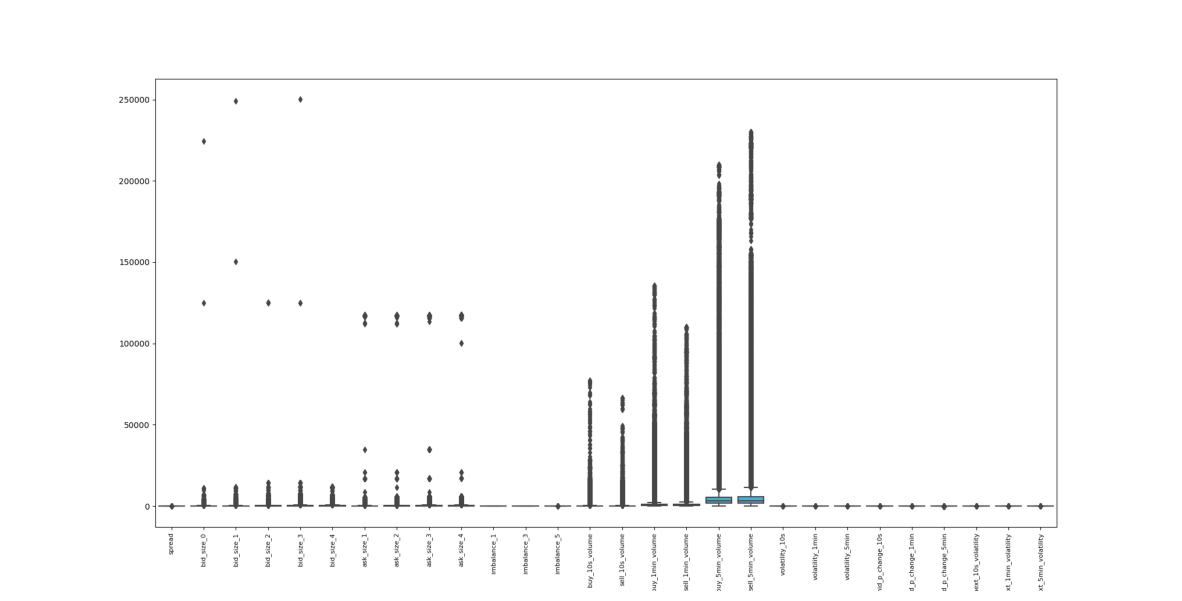

In [144]:
# Boxplots
# plt.figure(figsize=(20, 10))
# sns.boxplot(df)
# plt.xticks(fontsize=8, rotation=90)
# plt.savefig('images/boxplots_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/boxplots_all_outs.png')
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.axis('off')
plt.show()

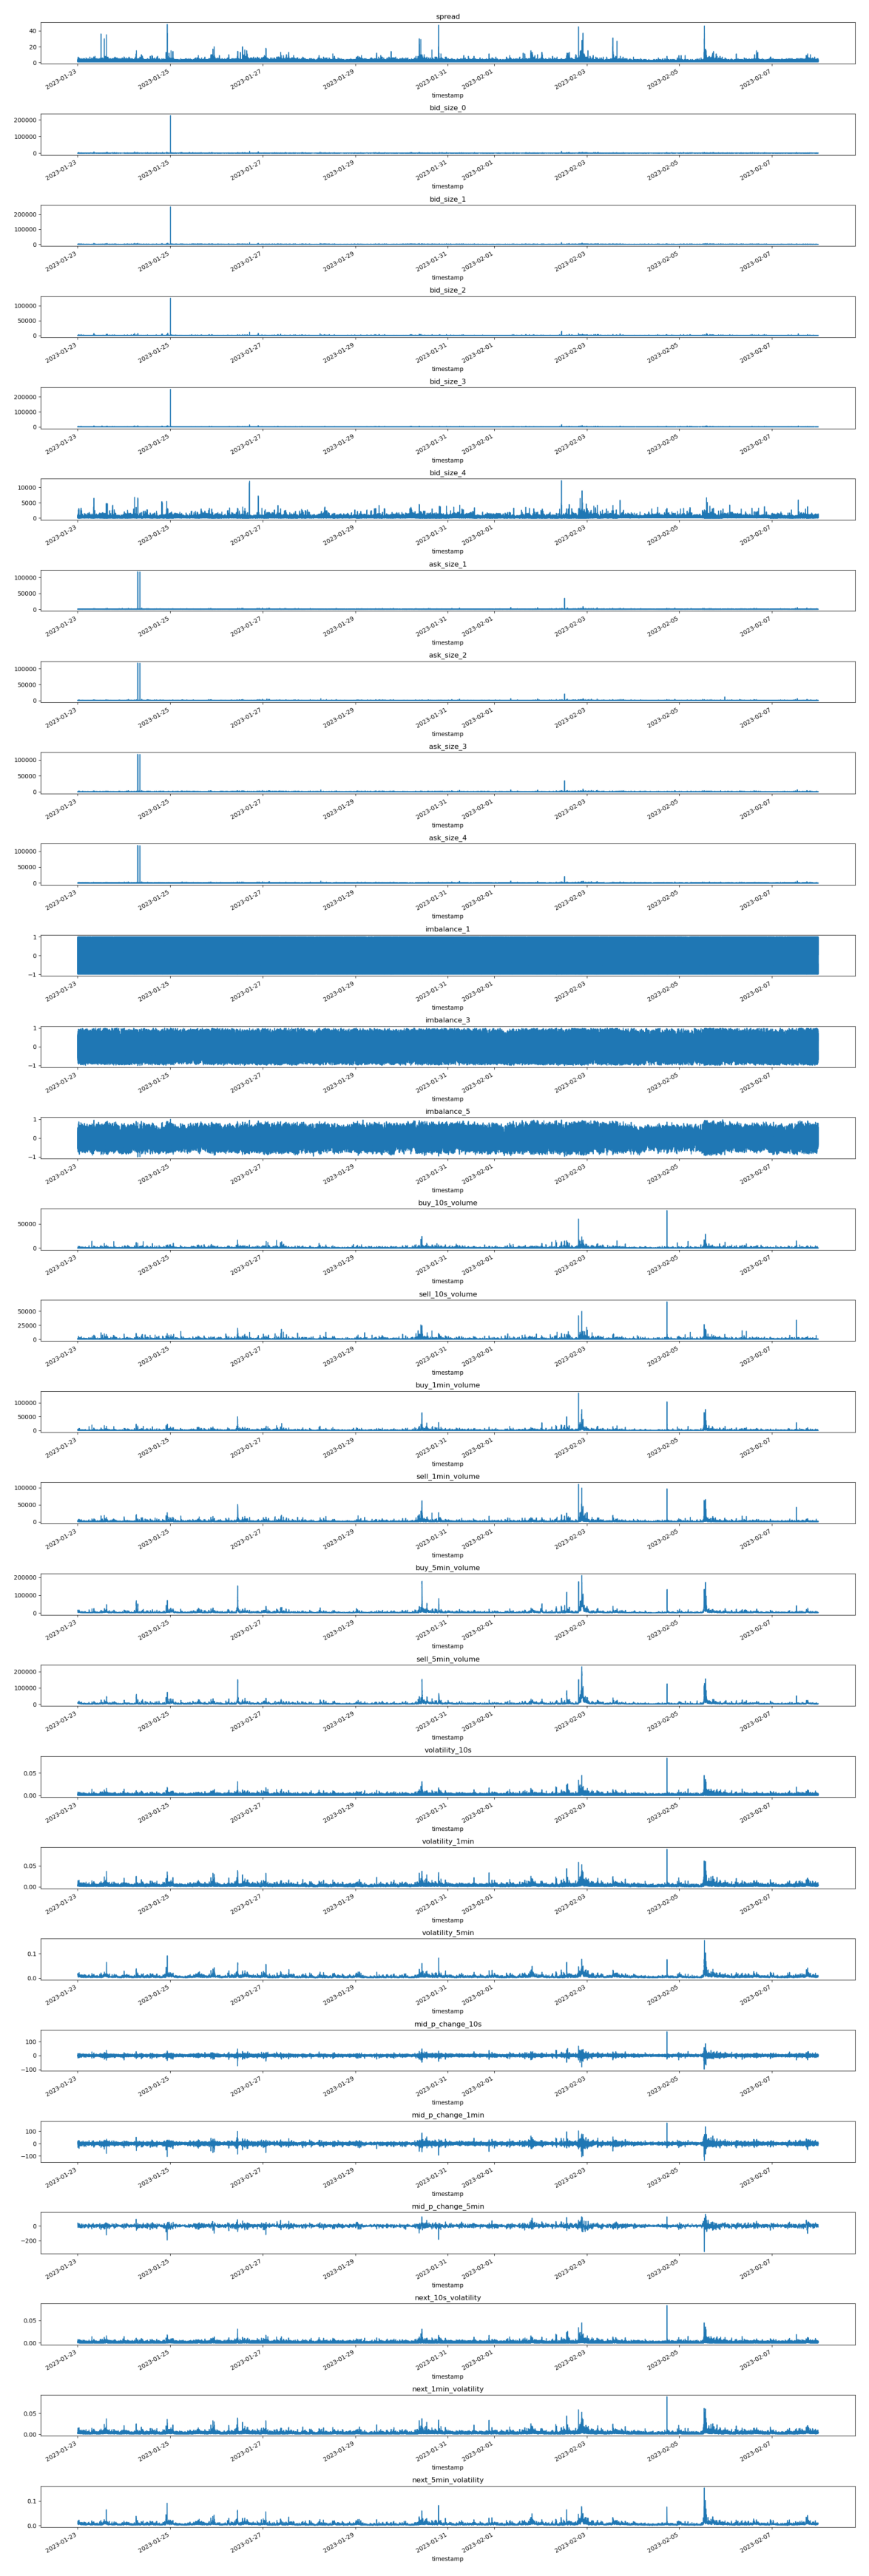

In [145]:
# Plotear líneas de cada variable:
# fig, axs = plt.subplots(len(df.columns), 1, figsize=(20, 60))
# for i, col in enumerate(df.columns):
#     df[col].plot(ax=axs[i], title=col)
# plt.tight_layout()
# plt.savefig('images/lineplots_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/lineplots_all_outs.png')
plt.figure(figsize=(15,45))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Revisión de la granularidad

Revisamos la distribución de observaciones por horas:

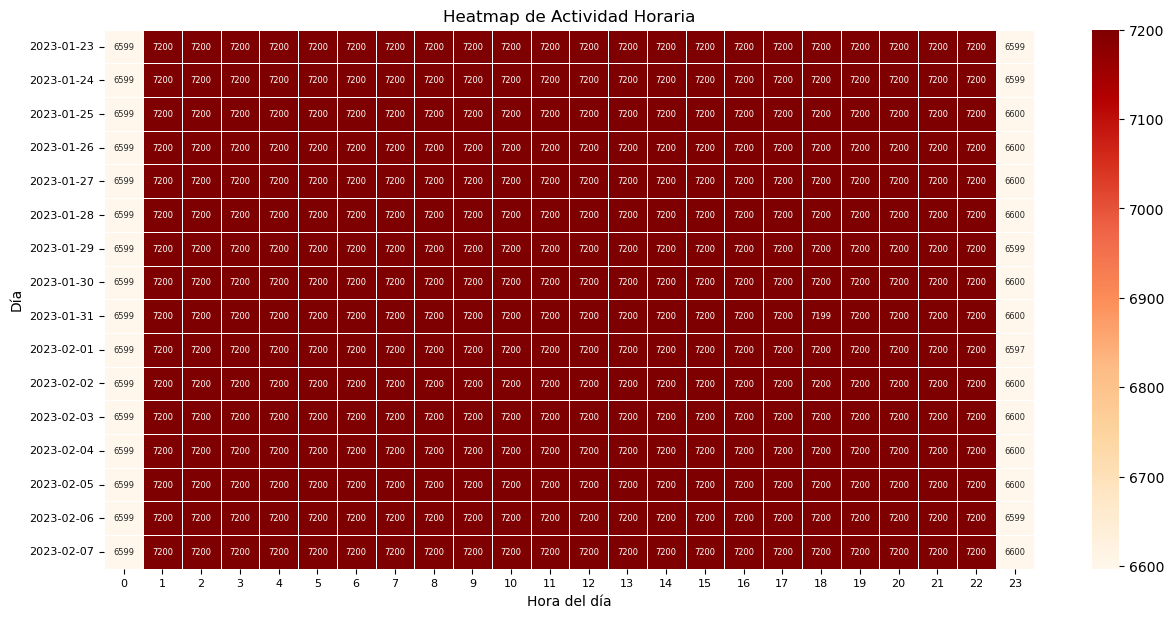

In [146]:
# Remuestrear los datos por hora y cuenta el número de registros por hora
df_resampled = df.resample('H').size().reset_index(name='count')
df_resampled.columns = ['timestamp', 'count']

# Extraer el día y la hora de la columna 'timestamp'
df_resampled['day'] = df_resampled['timestamp'].dt.date
df_resampled['hour'] = df_resampled['timestamp'].dt.hour

# Crear una tabla pivote para el heatmap
heatmap_data = df_resampled.pivot(index='day', columns='hour', values='count')

# Dibujar el heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(heatmap_data, cmap='OrRd', linewidths=0.5, annot=True, fmt=".0f", annot_kws={"size": 6})  # Ajusta el tamaño con "size"
plt.title('Heatmap de Actividad Horaria')
plt.xticks(size=8)
plt.yticks(size=8)
plt.ylabel('Día')
plt.xlabel('Hora del día')
plt.show()

La temperatura de los recuadros representa la cantidad de observaciones contenidas en cada hora, de cada día, a lo largo del dataset. Observamos una distribución consistente y homogénea, consistente con la granularidad media de 0.5 segundos, 7200 por hora.

Los recuadors de color claro indican datos faltantes, aunque también consistentes. Estos corresponden a los 10 minutos de posible cierre del sistema de recolección de datos, a medianoche todos los días.

#### Estacionareidad

La estacionariedad se refiere a una propiedad de las series de tiempo en la cual las características estadísticas (como la media, la varianza y la estructura de autocorrelación) no cambian con el tiempo. En otras palabras, una serie estacionaria tiene propiedades que son consistentes a lo largo del tiempo.

La estacionariedad es importante en el análisis de series de tiempo porque muchos métodos y modelos estadísticos asumen esta propiedad. Si una serie no es estacionaria, puede llevar a predicciones poco fiables o engañosas. Hacer que una serie sea estacionaria a menudo es un paso esencial antes de modelarla, ya que mejora la precisión y la interpretabilidad de los modelos.

Para evaluar la estacionariedad de una serie de tiempo, utilizamos la prueba de Dickey-Fuller aumentada (ADF). Esta prueba verifica la hipótesis nula (H0) de que una unidad de raíz está presente en una muestra de una serie de tiempo. Si la hipótesis nula se rechaza, se puede inferir que la serie de tiempo es estacionaria. El resultado de la prueba es un valor-p, y si este valor es menor que un nivel de significancia determinado (por ejemplo, 0.05), entonces podemos rechazar H0 y considerar que la serie es estacionaria.

Dada la gran cantidad de filas en `df` y el enorme costo computacional de la prueba, ejecutaremos `adfuller()` en una muestra del 10%.

**La evidencia sugiere que todas las variables son estacionarias. Estas fueron evaluadas en su primer 10% con la prueba de Dickey-Fuller.**

In [147]:
# from statsmodels.tsa.stattools import adfuller

# # Obtenemos la muestra del conjunto de datos:
# row_sample = int(df.shape[0] / 10)
# df_sample = df.iloc[:row_sample]

# # Ejecutamos adfuller() en cada columna del conjunto de datos y guardamos los valores-p:
# adfuller_p_values = []

# for col in df.columns:
#     p_value = adfuller(df_sample[col])[1]
#     adfuller_p_values.append(p_value)

# # Creamos un DataFrame que albergue loos valores-p de la prueba:
# adfuller_p_values_df = pd.DataFrame(
#     {'Series': df.columns,
#     'adfuller_p_values': adfuller_p_values}
# )
# # Verificamos si los valores-p son inferiores al umbral de significancia:
# adfuller_p_values_df['H0_rejected'] = adfuller_p_values_df['adfuller_p_values'] < 0.05

# # Guardamos los valores-p obtenidos en un archivo csv:
# adfuller_data = adfuller_p_values_df.to_csv('eda/adfuller_all_outs.csv')

# Imprimimos:
adfuller_data = pd.read_csv('eda/adfuller_all_outs.csv', index_col=0)
adfuller_data

,Series,adfuller_p_values,H0_rejected
0,spread,0.000000e+00,True
1,bid_size_0,0.000000e+00,True
2,bid_size_1,0.000000e+00,True
3,bid_size_2,0.000000e+00,True
4,bid_size_3,0.000000e+00,True
5,bid_size_4,0.000000e+00,True
6,ask_size_1,0.000000e+00,True
7,ask_size_2,0.000000e+00,True
8,ask_size_3,0.000000e+00,True
9,ask_size_4,0.000000e+00,True


#### Autocorrelación

In [148]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Número de variables
# n_vars = df_sample.shape[1]

# # Creamos una cuadrícula de subgráficos:
# fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(12, 4 * n_vars))

# for i, column in enumerate(df_sample.columns):
#     plot_acf(df_sample[column], lags=50, alpha=0.05, ax=axes[i, 0], title=f"ACF de {column}")
#     plot_pacf(df_sample[column], lags=50, alpha=0.05, ax=axes[i, 1], title=f"PACF de {column}")

# plt.tight_layout()
# plt.savefig('images/acf_pacf_all_outs.png', dpi='figure')
# plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/acf_pacf_all_outs.png')
# plt.figure(figsize=(20,100))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

### Multicolinealidad

Para detectar posible multicolinealidad entre las variables características, utilizamos el factor de inflación de la varianza (VIF). 

In [149]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

Y_list = ["mid_p_change_10s", "mid_p_change_1min", "mid_p_change_5min", "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

# # Y = df[Y_list]
# Y = df[target_var]

# # Definimos la variable objetivo y variables características escaladas 
# X = df.drop(columns=Y_list)

# # VIF dataframe
# vif_data_all_outs = pd.DataFrame()
# vif_data_all_outs["feature"] = X.columns

# # Calculamos VIF para cada variable característica:
# vif_data_all_outs["VIF"] = [variance_inflation_factor(X.values, i)
#                    for i
#                    in range(len(X.columns))]

# # Almacenar el DataFrame como csv: 
# vif_data_all_outs.to_csv('eda/vif_data_all_outs.csv')

# # Importar datos de VIF:
vif_data_all_outs = pd.read_csv('eda/vif_data_all_outs.csv', index_col=0)
vif_data_all_outs = vif_data_all_outs.sort_values(by="VIF")

# Imprimir VIF:
vif_data_all_outs

,feature,VIF
6,ask_size_1,1.163914
7,ask_size_2,1.233426
1,bid_size_0,1.236357
9,ask_size_4,1.296454
8,ask_size_3,1.308001
2,bid_size_1,1.403634
10,imbalance_1,1.492434
4,bid_size_3,1.765008
3,bid_size_2,1.904443
14,sell_10s_volume,2.358865


En `df` hay varias características con multicolinealidad elevada (mayores a 5). Las variables `ask_size_0` y `bid_size_4` presentaban multicolinealidad perfecta, lo que significa que una podía ser representada como una combinación lineal de la otra. Por esta razón, se elminó la primera. También, al crear nuevas variables, aparecerán varias con multicolinalidad perfecta. 

Podemos abordar el problema de multicolinealidad con don enfoques:

1. Eliminar variables con alta multicolinealidad, de mayores a menores y una por una, hasta que tengamos un subconjunto de variables con baja multicolinealidad. Para lograr este enfoque de fuerza bruta, creamos la función `drop_high_vif_vars()`. Si bien esta función elimina variables de forma automática e iterativa, es necesario considerar que puede haber variables eliminadas que sí puedan ser un aporte al modelo, por lo que es necesario utilizarla con cautela.

2. Utilizar modelos de regularización Lasso y Ridge para penalizar, los coeficientes de variables con alta multicolinealidad. 

Este último enfoque es el más eficiente en términos de eficiencia computacional. 

In [9]:
import nolds

# Analizamos el grado de caos de las variables objetivo, utilizando el Mayor Exponente de Lyapunov (LLE):
for col in Y_list:
    cv_lle = cross_validated_lle(df[col], cv=10, seed=123)
    print(f"Media CV LLE de '{col}': ", np.mean(cv_lle))

Media CV LLE de 'mid_p_change_10s':  0.027208402756026307
Media CV LLE de 'mid_p_change_1min':  0.0015187625299045398
Media CV LLE de 'mid_p_change_5min':  -0.00022441014908901989
Media CV LLE de 'next_10s_volatility':  0.005632905094787753
Media CV LLE de 'next_1min_volatility':  0.006240792930850054
Media CV LLE de 'next_5min_volatility':  -7.246757256916283e-05


In [12]:
for col in Y_list:
    alfa = nolds.dfa(df[col][:10000:])
    print(f"Alfa de '{col}': {alfa}")

Alfa de 'mid_p_change_10s': 1.3315830564854854
Alfa de 'mid_p_change_1min': 1.7963110325842335
Alfa de 'mid_p_change_5min': 1.9824350980300551
Alfa de 'next_10s_volatility': 1.1312820721650716
Alfa de 'next_1min_volatility': 1.6279113317606628
Alfa de 'next_5min_volatility': 1.924627959307666


In [17]:
import nolds

# Analizamos el grado de autoafinidad estadística de las variables objetivo, utilizando el Análisis de Fluctuación sin Tendencia (DFA):
for col in Y_list:
    cv_lle = cross_validated_dfa(df[col], cv=10, seed=123)
    print(f"Alfa medio CV DFA de '{col}': ", np.mean(cv_lle))

Media CV DFA de 'mid_p_change_10s':  1.2712388050472352
Media CV DFA de 'mid_p_change_1min':  1.796025988102502
Media CV DFA de 'mid_p_change_5min':  1.9873158496913768
Media CV DFA de 'next_10s_volatility':  1.1431490158268605
Media CV DFA de 'next_1min_volatility':  1.6523121870557727
Media CV DFA de 'next_5min_volatility':  1.9321061108254827


**Interpretación**:

- `mid_p_change_10s`: Tiene correlaciones a largo plazo y cierta sensibilidad a las condiciones iniciales, lo que sugiere que puede haber alguna predictibilidad pero con cierta incertidumbre.

- `mid_p_change_1min` y `mid_p_change_5min`: Ambas variables muestran fuertes correlaciones a largo plazo (especialmente `mid_p_change_5min`), pero la sensibilidad a las condiciones iniciales es baja o estable, lo que sugiere que pueden ser más predecibles que `mid_p_change_10s`.

- `next_10s_volatility`: Presenta correlaciones a largo plazo y baja sensibilidad a las condiciones iniciales, lo que sugiere que puede haber alguna predictibilidad.

- `next_1min_volatility`: Aunque tiene fuertes correlaciones a largo plazo, la baja sensibilidad a las condiciones iniciales sugiere que puede ser relativamente predecible.

- `next_5min_volatility`: A pesar de las fuertes correlaciones a largo plazo, la estabilidad en términos de condiciones iniciales sugiere que esta variable podría ser la más predecible de las tres relacionadas con la volatilidad.

**Conclusión**:

- Las variables relacionadas con los cambios en el precio medio parecen tener fuertes correlaciones a largo plazo, especialmente cuando se observan en ventanas de tiempo más largas (`mid_p_change_5min`).

- Las variables relacionadas con la volatilidad futura (next_volatility) también muestran correlaciones a largo plazo, pero la variable `next_5min_volatility` parece ser la más estable y, por lo tanto, potencialmente la más predecible.

# Ingeniería de características

In [163]:
# Cargar datos:
df = pd.read_parquet('datasets/merged_data.parquet')

# Establecer 'timestamp' como índice:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Definir lista de variables objetivo candidatas:
Y_list = ["mid_p_change_10s", "mid_p_change_1min", "mid_p_change_5min", "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

target_var = 'mid_p_change_5min'

## Tratamiento de valores atípicos

In [164]:
df_capped = pd.DataFrame()

multiplier = 3 # con valor 3, los residuos del modelos son más armoniosos

for col in df.columns:
    df_capped[col] = apply_outlier_capping(df[col], multiplier=multiplier)

df_capped.index = df.index
df = df_capped.copy()

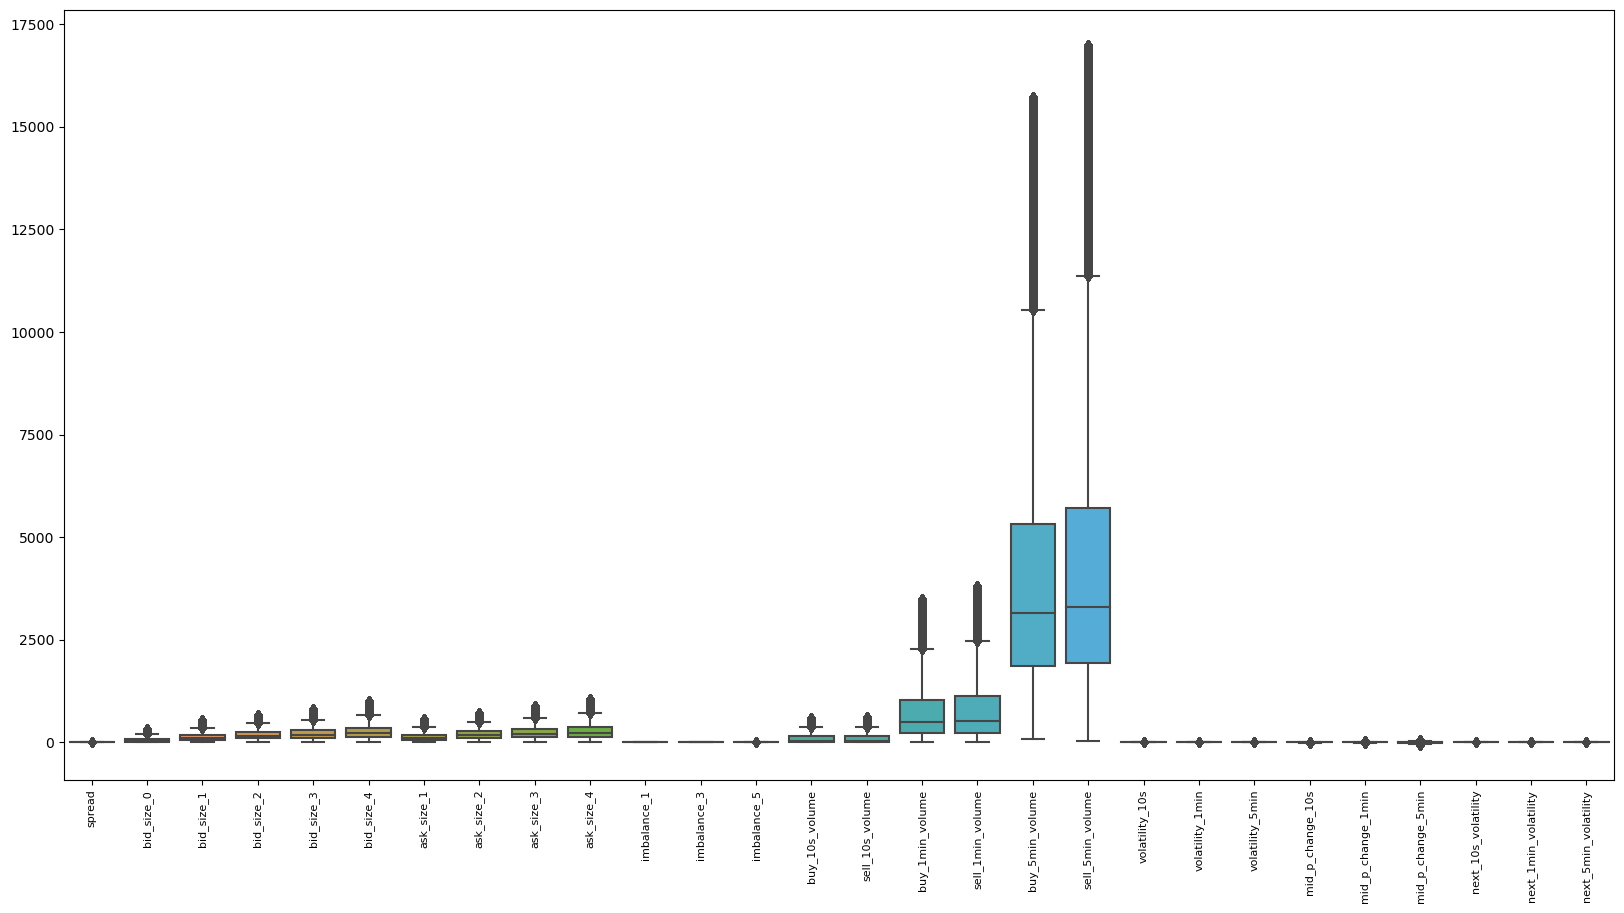

In [165]:
# Boxplots
plt.figure(figsize=(20, 10))
sns.boxplot(df)
plt.xticks(fontsize=8, rotation=90)
plt.show()

In [166]:
# # Plotear líneas de cada variable:
# fig, axs = plt.subplots(len(df.columns), 1, figsize=(20, 60))
# for i, col in enumerate(df.columns):
#     df[col].plot(ax=axs[i], title=col)
# plt.tight_layout()
# plt.savefig('images/lineplots_capped.png', dpi='figure')
# plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/lineplots_capped.png')
# plt.figure(figsize=(15,45))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

## Creación de características

In [167]:
# La media móvil puede ayudar a suavizar los datos y capturar tendencias a corto plazo.

# Variables de 10 segundos
variables_10s = ['spread', 'bid_size_0', 'imbalance_1','buy_10s_volume', 'sell_10s_volume', 'volatility_10s']

# Variables de 1 minuto:
variables_1min = ['imbalance_3', 'buy_1min_volume', 'sell_1min_volume', 'volatility_1min']

# Medias móviles:
for var in variables_10s:
    df[f'{var}_ma_1min'] = df[var].rolling(window=120).mean()  # Media móvil de 1 minuto
    df[f'{var}_ma_5min'] = df[var].rolling(window=600).mean()  # Media móvil de 5 minutos

for var in variables_1min:
    df[f'{var}_ma_5min'] = df[var].rolling(window=600).mean()  # Media móvil de 5 minutos

In [168]:
# El momentum es una medida de la tendencia reciente en los datos y puede ser útil para predecir cambios futuros.

# # Momentum:
# df['momentum_10s'] = df['mid_p_change_10s'] - df['mid_p_change_10s'].shift(20)  # Momentum de 10 segundos
# df['momentum_1min'] = df['mid_p_change_1min'] - df['mid_p_change_1min'].shift(120)  # Momentum de 1 minuto
# df['momentum_5min'] = df['mid_p_change_5min'] - df['mid_p_change_5min'].shift(600)  # Momentum de 5 minutos

In [169]:
# Estos cambios pueden capturar movimientos repentinos en el desbalance de compra y venta.

# Cambio en el desbalance:
df['imbalance_1_change'] = df['imbalance_1'].diff()
df['imbalance_3_change'] = df['imbalance_3'].diff()
df['imbalance_5_change'] = df['imbalance_5'].diff()

In [170]:
# útil para identificar períodos de compra o venta intensa. El uso del logaritmo puede ayudar a suavizar valores extremos.

# Relación Volumen de Compra/Venta. Nota: El divisor suma 1 para evitar valores infinitos.
df['log_buy_sell_volume_ratio_10s'] = np.log(df['buy_10s_volume'] / (df['sell_10s_volume'] + 1) + 1)
df['log_buy_sell_volume_ratio_1min'] = np.log(df['buy_1min_volume'] / (df['sell_1min_volume'] + 1) + 1)
df['log_buy_sell_volume_ratio_5min'] = np.log(df['buy_5min_volume'] / (df['sell_5min_volume'] + 1) + 1)

In [171]:
# Las características con retraso (lag) pueden capturar relaciones temporales en los datos.

# Características lag, creadas según lo observado en los gráficos de ACF y PACF:
for col in ['spread', 'imbalance_1', 'imbalance_3', 'imbalance_5']:
        df[f'{col}_lag_1'] = df[col].shift(1)

# # Crear lags para variable objetivo:
# target_var = 'mid_p_change_10s'
# num_lags = 4
# for lag in range(1, num_lags + 1):
#     df[f'{target_var}_lag_{lag}'] = df[target_var].shift(lag)

In [172]:
# Las características de interacción pueden capturar relaciones no lineales entre las variables.

# Características de Interacción:
df['spread_imbalance1'] = df['spread'] * df['imbalance_1']

In [173]:
# La puntuación estándar es útil para identificar cuántas desviaciones estándar está un punto de datos del promedio móvil.

# # Puntuación estándar para ventanas de corto (100), medio (500) y largo (3000) plazo. Nota: El divisor suma 1 para evitar valores infinitos.
# df['z_score_spread_100'] = (df['spread'] - df['spread'].rolling(window=100).mean()) / (df['spread'].rolling(window=100).std() + 1)
# df['z_score_spread_500'] = (df['spread'] - df['spread'].rolling(window=500).mean()) / (df['spread'].rolling(window=500).std() + 1)
# df['z_score_spread_3000'] = (df['spread'] - df['spread'].rolling(window=3000).mean()) / (df['spread'].rolling(window=3000).std() + 1) 

for window in [20, 120, 600]: # ventanas de 10 segundos, 1 minuto, 5 minutos:
     df[f'z_score_spread_{window}'] = (df['spread'] - df['spread'].rolling(window=window).mean()) / \
         (df['spread'].rolling(window=window).std() + 1)

In [174]:
# La oferta y demanda totales son útiles para reducir la dimensionalidad y capturar las tendencias generales.

# Variable "bid" acumulativa.
df['bid_total_size'] = df[['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4']].sum(axis=1)
df.drop(columns=['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4'], inplace=True)

# Variable "ask" acumulativa.
df['ask_total_size'] = df[['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4']].sum(axis=1)
df.drop(columns=['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4'], inplace=True)

# Relación Bid/Ask: Esta es una característica importante que puede capturar la dinámica entre las ofertas y demandas en el mercado. 
# Una relación alta podría indicar una mayor demanda, mientras que una relación baja podría indicar una mayor oferta.

# Relación Bid/Ask
df['bid_ask_ratio'] = df['bid_total_size'] / df['ask_total_size']

In [175]:
# El Rango Verdadero (TR) y el Rango Verdadero Medio (ATR) son indicadores técnicos utilizados para medir la volatilidad del mercado.
# El ATR, en particular, proporciona una medida promedio de la volatilidad durante un período de tiempo específico, definido como 1 hora.

# Cálculo del Rango Verdadero (TR):
current_value = df['spread']
previous_value = df['spread'].shift(1)

# TR se calcula como el máximo entre: 
# (1) la diferencia entre el valor actual y el anterior, 
# (2) el valor absoluto entre el valor actual y el anterior, 
# (3) el valor absoluto entre el valor anterior y el actual.
df['tr'] = np.maximum(current_value - previous_value, 
                      np.maximum(np.abs(current_value - previous_value), 
                                 np.abs(previous_value - current_value)))

# Cálculo del Rango Verdadero Medio (ATR) usando un promedio móvil simple para un período de 1 hora:
window_size = 60 * 60 * 2  # 1 hora con granularidad de 0.5 segundos
df['atr'] = df['tr'].rolling(window=window_size).mean()

# Eliminar la columna 'tr' ya que es solo un cálculo intermedio:
df.drop(columns=['tr'], inplace=True)

In [176]:
# Eliminar las filas NaN generadas durante la creación de características:
df = df.dropna()

### Extracción de variables características y objetivo

In [177]:
# Extraer variables características:
X = df.drop(columns=Y_list)

# Extraer variable objetivo:
Y = df[target_var]

In [178]:
df.columns

Index(['spread', 'imbalance_1', 'imbalance_3', 'imbalance_5', 'buy_10s_volume',
       'sell_10s_volume', 'buy_1min_volume', 'sell_1min_volume',
       'buy_5min_volume', 'sell_5min_volume', 'volatility_10s',
       'volatility_1min', 'volatility_5min', 'mid_p_change_10s',
       'mid_p_change_1min', 'mid_p_change_5min', 'next_10s_volatility',
       'next_1min_volatility', 'next_5min_volatility', 'spread_ma_1min',
       'spread_ma_5min', 'bid_size_0_ma_1min', 'bid_size_0_ma_5min',
       'imbalance_1_ma_1min', 'imbalance_1_ma_5min', 'buy_10s_volume_ma_1min',
       'buy_10s_volume_ma_5min', 'sell_10s_volume_ma_1min',
       'sell_10s_volume_ma_5min', 'volatility_10s_ma_1min',
       'volatility_10s_ma_5min', 'imbalance_3_ma_5min',
       'buy_1min_volume_ma_5min', 'sell_1min_volume_ma_5min',
       'volatility_1min_ma_5min', 'imbalance_1_change', 'imbalance_3_change',
       'imbalance_5_change', 'log_buy_sell_volume_ratio_10s',
       'log_buy_sell_volume_ratio_1min', 'log_buy_sell_

## Relaciones de las variables características con la variable objetivo

In [179]:
# # Calcular la matriz de correlación
# corr = pd.concat([X, Y], axis=1).corr()

# # Extraer las correlaciones de 'y' con todas las otras variables
# y_corr = corr.loc[:, target_var].sort_values()

# # Crear un DataFrame con las correlaciones ordenadas de 'y'
# sorted_corr = pd.DataFrame(y_corr).T.drop(columns=[target_var])

# # Crear un mapa de colores que va desde azul (frío) a blanco (neutro) a rojo (caliente)
# cmap = sns.diverging_palette(250, 0, s=75, l=40, n=9, as_cmap=True)

# # Ajustar el tamaño del gráfico para que sea más ancho
# plt.figure(figsize=(15, 4))
# sns.heatmap(sorted_corr, annot=False, cmap=cmap, cbar=True, linewidths=0, linecolor='none')

# # Establecer el título y ajustar las etiquetas
# plt.title(f'Correlación con {target_var}')
# plt.xticks(rotation=45, ha='right', fontsize=6)

#  # Ocultar el nombre del índice en el eje y
# plt.yticks([]) 

# plt.tight_layout()
# plt.show()


In [180]:
# df_sample = df.sample(1000)

# X_sample = df_sample.drop(columns=Y_list)
# y_sample = df_sample[target_var]

# # Número de características en X
# num_features = X_sample.shape[1]

# # Determinar el número de filas y columnas para la cuadrícula
# num_rows = int(np.ceil(np.sqrt(num_features)))
# num_cols = int(np.ceil(num_features / num_rows))

# # Crear una cuadrícula de subplots
# fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5*num_cols, 4*num_rows))

# # Si solo hay una característica, axes no es una lista, así que lo convertimos en una lista para la iteración
# if num_features == 1:
#     axes = [axes]

# # Aplanar la lista de ejes para facilitar la iteración
# axes = np.array(axes).flatten()

# # Iterar sobre cada característica y crear un diagrama de dispersión con línea de regresión
# for i, col in enumerate(X_sample.columns):
#     sns.regplot(x=X_sample[col], y=y_sample, ax=axes[i], color='blue', line_kws={"color": "red"})
#     axes[i].set_title(f'{col} vs {target_var}')
#     axes[i].set_xlabel(col)
#     axes[i].set_ylabel(target_var)

# # Eliminar cualquier eje adicional que no se use
# for j in range(num_features, num_rows*num_cols):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()


## Análisis de Componentes Principales

In [181]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

# Escalar las características:
X_scaler = RobustScaler()
X_scaled = X_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

Núm. de componentes principales que acumulan 99.5% de varianza:  20


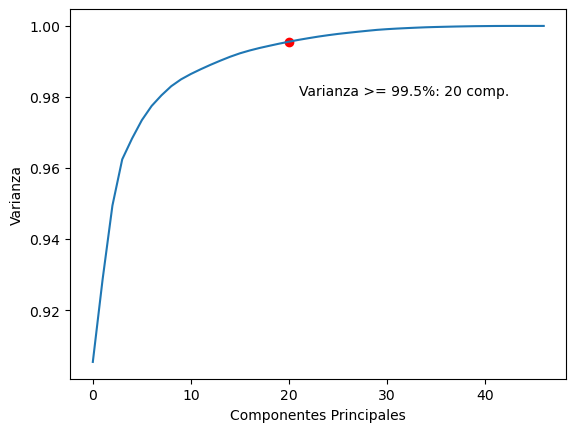

In [182]:
# Instanciamos, ajustamos, transformamos y obtenemos el ratio de varianza explicada:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
exp_variance = pca.explained_variance_ratio_

# Número mínimo de componentes principales que acumulan al menos un valor requerido de varianza:

requested_variance = 0.995
exp_variance_cum_sum = np.cumsum(exp_variance)
n_components = min(np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1, len(exp_variance_cum_sum) - 1)
#n_components = np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1
print(f"Núm. de componentes principales que acumulan {requested_variance * 100}% de varianza: ", n_components)

# Graficamos:
plt.plot(exp_variance_cum_sum)
plt.scatter(n_components, exp_variance_cum_sum[n_components], color='red', marker='o')
plt.text(n_components+1, exp_variance_cum_sum[n_components]-.015, f"Varianza >= {requested_variance * 100}%: {n_components} comp.", fontsize=10)
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza')
plt.show()

In [183]:
# Crear un DataFrame con las componentes principales seleccionadas
X_pca_df = pd.DataFrame(data=X_pca[:, :n_components], columns=[f'PC{i}' for i in range(1, n_components + 1)], index=X.index)
X_pca_df.shape

(2738376, 20)

En la muestra tomada, la prueba de Dickey-Fuller aumentada fuertemente sugiere que las todas series son estacionarias. Este es un dato importante previo al modelado y predicción de los datos. Sin embargo, es necesario actuar con cautela, puesto que carecemos de certeza si los datos se mantienen estacionarios en todo su espacio temporal.

In [184]:
# Obtener las variables características regularizadas con una constante:
const_RF_X = sm.add_constant(X_pca_df)

Y = df[target_var].to_frame()

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(Y, const_RF_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      mid_p_change_5min   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                 1.719e+04
Date:                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:58:54   Log-Likelihood:            -1.1327e+07
No. Observations:             2738376   AIC:                         2.265e+07
Df Residuals:                 2738355   BIC:                         2.265e+07
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2932      0.009     32.047      0.0

### Regularización Lasso y Ridge

Para lidiar con los problemas de selección de variables y alta multicolinealidad de los datos, ajustaremos modelos de regularización Lasso y Ridge. Lasso y Ridge son técnicas de regularización para la regresión. Lasso selecciona características al hacer que algunos coeficientes sean cero, simplificando el modelo, mientras que Ridge aborda la multicolinealidad al penalizar el tamaño de los coeficientes. Ambas técnicas buscan prevenir el sobreajuste y mejorar la robustez del modelo, especialmente en presencia de muchas variables predictoras.

In [185]:
# from sklearn.preprocessing import RobustScaler

# # Escalamos las características con la clase StandardScaler()
# scaler = RobustScaler()
# df_scaled = scaler.fit_transform(df)
# df_scaled = pd.DataFrame(
#     df_scaled,
#     columns=scaler.get_feature_names_out(df.columns)
#     )

Y_scaler = RobustScaler()
Y_scaled = Y_scaler.fit_transform(Y)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns, index=Y.index)
X_scaled = X_pca_df

In [186]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Dividimos los datos en conjuntos de entrenamiento y prueba:

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_scaled) * 0.8)

# Dividir los datos
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = Y_scaled[target_var][:train_size], Y_scaled[target_var][train_size:]

# Entrenamos el modelo Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Entrenamos el modelo Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

print("Modelo Lasso: ", lasso_mse)
print("Modelo Ridge: ", ridge_mse)

Modelo Lasso:  0.9731800595659955
Modelo Ridge:  0.8772058331904812


In [187]:
from sklearn.linear_model import LassoCV

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_scaled, Y_scaled)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)

Alpha óptimo para Lasso: 0.001
MSE Lasso:  0.8722979027891717


In [188]:
from sklearn.linear_model import RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_scaled, Y_scaled)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 100.0
MSE Ridge:  0.8720155983877439


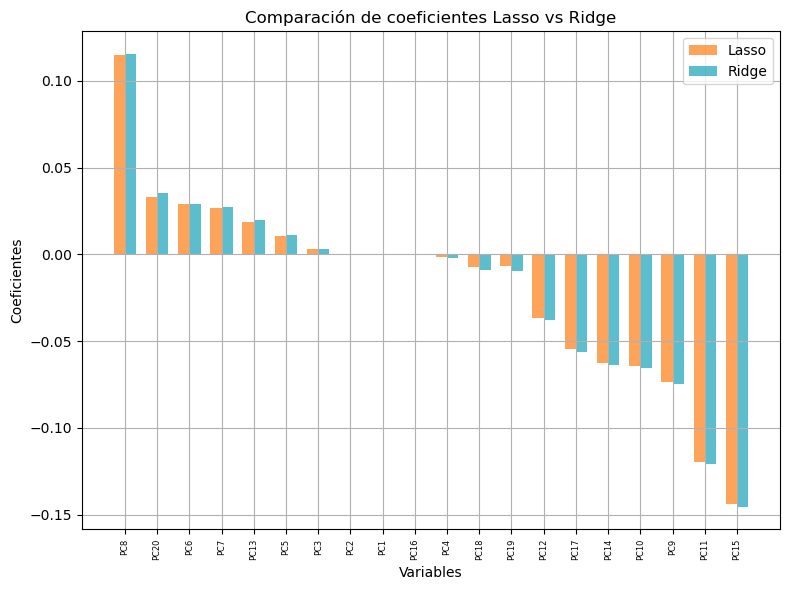

In [189]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_scaled.columns, 
    'lasso_coefs': lasso_opt.coef_.flatten(),
    'ridge_coefs': ridge_opt.coef_.flatten()}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by='ridge_coefs', ascending=False)

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [190]:
# Utilizar la función filtro de variables con Lasso y Ridge: 
PCA_L1L2_X_list = select_features_from_regularization(
    regularization_coefs, # Matriz de coeficientes de regularización
    lasso_threshold=0.01, # 0.02
    ridge_threshold=0.01 # 0.02
    )

PCA_L1L2_X = X_pca_df[PCA_L1L2_X_list]

# Revisar las variables seleccionadas:
PCA_L1L2_X_list

['PC9',
 'PC13',
 'PC6',
 'PC11',
 'PC12',
 'PC7',
 'PC10',
 'PC15',
 'PC8',
 'PC14',
 'PC20',
 'PC17',
 'PC5']

In [191]:
# ols_results = pd.DataFrame()
# ols_results['params'] = model.params
# ols_results['pvalues'] = model.pvalues

# # Definir un umbral mínimo para coeficientes:
# coef_criteria = 0.0001

# ols_results_filtered = ols_results.drop('const', axis=0)
# ols_results_filtered = ols_results_filtered[
#     (ols_results_filtered['params'] >= coef_criteria) & 
#     (ols_results_filtered['pvalues'] <= 0.05)
#     ]

# # Lista de variables escogidas por L1L2 y OLS:
# L1L2_OLS_X = X_pca_df[ols_results_filtered.index]
# ols_results_filtered.index

# Modelo Long Short-Term Memory (LSTM)

### Definición de subconjuntos de datos

In [192]:
from sklearn.preprocessing import RobustScaler
from scipy.stats import yeojohnson

X_scaled = X_pca_df[PCA_L1L2_X_list]

# Transformación Yeo-Johnson sobre la variable objetivo. 
# La transformación no mejora sustancialmente la predicción pero ayuda a una convergencia más rápida.
yj_Y, lambda_best_fit = yeojohnson(Y)

# Escalar las variables objetivo
Y = pd.DataFrame(yj_Y, index=Y.index)
Y_scaler = RobustScaler()
Y_scaled = Y_scaler.fit_transform(Y)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns, index=Y.index)

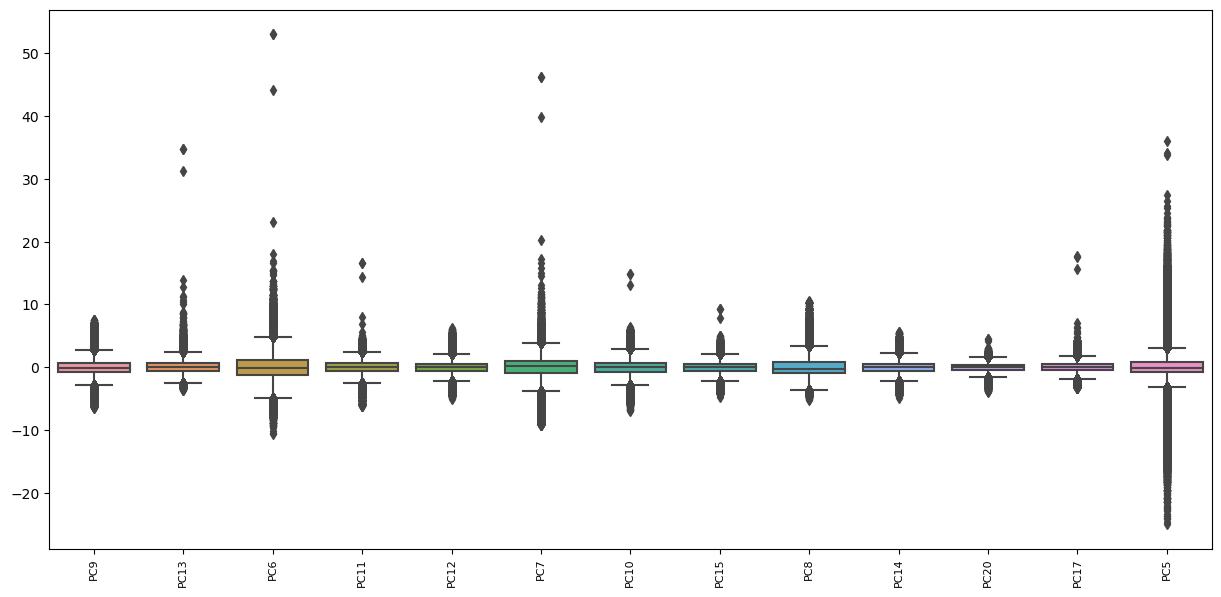

In [193]:
# Boxplots
plt.figure(figsize=(15, 7))
sns.boxplot(X_scaled)
plt.xticks(fontsize=8, rotation=90)
# plt.savefig('images/boxplots_all_outs.png', dpi='figure')
plt.show()

In [194]:
# One-hot encoding para el día de la semana:
days_encoded = pd.get_dummies(X_scaled.index.dayofweek, prefix='day')

# One-hot encoding para la hora del día:
hours_encoded = pd.get_dummies(X_scaled.index.hour, prefix='hour')

# Asegurarse de que los DataFrames codificados tengan el mismo índice que X_scaled:
days_encoded.index = X_scaled.index
hours_encoded.index = X_scaled.index

# Concatenar las columnas codificadas al DataFrame original
X_scaled = pd.concat([X_scaled, days_encoded, hours_encoded], axis=1)
X_scaled = X_scaled.astype('float32')

# Eliminar variables de día y hora de referencia (lunes y hora 0, respectivamente):
X_scaled.drop(columns=['hour_0', 'day_0'], inplace=True)

In [195]:
# Dividir los datos en entrenamiento y prueba:
train_size = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
Y_train, Y_test = Y_scaled[:train_size], Y_scaled[train_size:]

# Invertir el escalado de los datos de prueba a escala original:
Y_test_rescaled = Y_scaler.inverse_transform(Y_test)

# Dividir el conjunto de entrenamiento en entrenamiento (80% de train_size) y validación (20% de train_size)
val_size = int(train_size * 0.7)
X_train, X_val = X_train[:val_size], X_train[val_size:]
Y_train, Y_val = Y_train[:val_size], Y_train[val_size:]

# Cambiar la forma de los datos para LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Definir la cantidad de nodos de entrada y de salida:
window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_scaled.shape[1]

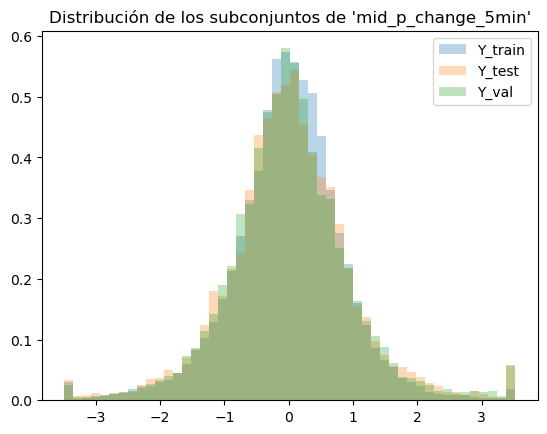

In [196]:
# Visualizar  distribución de variable objetivo:
plt.hist(Y_train, alpha=0.3, density=True, label="Y_train", bins=50)
plt.hist(Y_test, alpha=0.3, density=True, label="Y_test", bins=50)
plt.hist(Y_val, alpha=0.3, density=True, label="Y_val", bins=50)
plt.title(f"Distribución de los subconjuntos de '{target_var}'")
plt.legend()
plt.show()

In [197]:
from scipy.stats import ks_2samp

# 2. Prueba de Kolmogorov-Smirnov para comparar las distribuciones
ks_statistic_train_test, ks_pvalue_train_test = ks_2samp(Y_train.values.ravel(), Y_test.values.ravel())
ks_statistic_train_val, ks_pvalue_train_val = ks_2samp(Y_train.values.ravel(), Y_val.values.ravel())
ks_statistic_test_val, ks_pvalue_test_val = ks_2samp(Y_test.values.ravel(), Y_val.values.ravel())

print(f"Prueba KS entre Y_train y Y_test: Estadístico = {ks_statistic_train_test:.4f}, p-valor = {ks_pvalue_train_test:.4f}")
print(f"Prueba KS entre Y_train y Y_val: Estadístico = {ks_statistic_train_val:.4f}, p-valor = {ks_pvalue_train_val:.4f}")
print(f"Prueba KS entre Y_test y Y_val: Estadístico = {ks_statistic_test_val:.4f}, p-valor = {ks_pvalue_test_val:.4f}")

Prueba KS entre Y_train y Y_test: Estadístico = 0.0286, p-valor = 0.0000
Prueba KS entre Y_train y Y_val: Estadístico = 0.0262, p-valor = 0.0000
Prueba KS entre Y_test y Y_val: Estadístico = 0.0132, p-valor = 0.0000


In [198]:
# Tasa de aprendizaje inicial:
initial_lr = 0.001

# Constante que determina la rapidez de decaimiento de initial_lr:
k = 0.001 # [0.001, 0.005, 0.01, 0.015, 0.02]

# Dropout generalizado:
dropout = 0.1

# Tasa de regularización L2:
l2_rate = 0.05

In [201]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.regularizers import l2

# Iniciar la red secuencial:
lstm_model = Sequential()

# Primera capa LSTM:
lstm_model.add( # Bidirectional(
     LSTM(60,
          activation='tanh', 
          input_shape=(window_size, n_features),
          dropout=dropout,
          recurrent_dropout=dropout,
          kernel_regularizer=l2(l2_rate), # Subir o bajar incrementa o disminuye el MSE de train y val, pero no disminuye la brecha
          recurrent_regularizer=l2(l2_rate),
          return_sequences=True  # Esto permite que la salida sea una secuencia, que alimentará la siguiente capa LSTM.
          )
     ) # )

# Capa de dropout previa a la capa densa:
lstm_model.add(Dropout(dropout))

# Segunda capa LSTM:
lstm_model.add( # Bidirectional(
     LSTM(50,
          activation='tanh',
          dropout=dropout,
          recurrent_dropout=dropout
          )
     ) # )

# # Capa de dropout previa a la capa densa:
# lstm_model.add(Dropout(dropout)) # <-- esto es raro, no debería estar aquí 

# Capa densa de salida:
lstm_model.add(Dense(n_outputs))

# Compilar el modelo:
optimizer = Adam(learning_rate=initial_lr)
lstm_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_squared_error'])

In [202]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import math

# Definir EarlyStopping:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0005,
    verbose=1,
    restore_best_weights=True
    )

# Definir el checkpoint del modelo:
checkpoint = ModelCheckpoint(
    'trained_models/best_model.h5',
    monitor='val_loss',
    save_best_only=True
    )

# Definir el LearningRateScheduler:
def exponential_decay(epoch, initial_lr=initial_lr, k=k):
    new_lr = initial_lr * math.exp(-k * epoch)
    return new_lr

lr_scheduler = LearningRateScheduler(exponential_decay)

# Entrenamiento del modelo:
train_history = lstm_model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=72,
    validation_data=(X_val, Y_val),
    verbose=2,
    shuffle=False,
    callbacks=[early_stopper, checkpoint, lr_scheduler]
    )

Epoch 1/20
21299/21299 - 172s - loss: 0.6605 - mean_squared_error: 0.7367 - val_loss: 0.7013 - val_mean_squared_error: 0.9140 - lr: 0.0010 - 172s/epoch - 8ms/step
Epoch 2/20
21299/21299 - 196s - loss: 0.6418 - mean_squared_error: 0.7254 - val_loss: 0.6974 - val_mean_squared_error: 0.9028 - lr: 9.9900e-04 - 196s/epoch - 9ms/step
Epoch 3/20
21299/21299 - 203s - loss: 0.6389 - mean_squared_error: 0.7223 - val_loss: 0.6944 - val_mean_squared_error: 0.9002 - lr: 9.9700e-04 - 203s/epoch - 10ms/step
Epoch 4/20
21299/21299 - 193s - loss: 0.6379 - mean_squared_error: 0.7211 - val_loss: 0.6941 - val_mean_squared_error: 0.8998 - lr: 9.9402e-04 - 193s/epoch - 9ms/step
Epoch 5/20
21299/21299 - 186s - loss: 0.6379 - mean_squared_error: 0.7207 - val_loss: 0.6941 - val_mean_squared_error: 0.8995 - lr: 9.9005e-04 - 186s/epoch - 9ms/step
Epoch 6/20
21299/21299 - 157s - loss: 0.6376 - mean_squared_error: 0.7203 - val_loss: 0.6936 - val_mean_squared_error: 0.8992 - lr: 9.8511e-04 - 157s/epoch - 7ms/step
E

In [203]:
import json

# Guardar el modelo completo en formato HDF5:
lstm_model.save('trained_models/lstm_model_pca_5m_vol.h5')

# # Guardar la historia como JSON:
# with open('trained_models/train_history_1.json', 'w') as file:
#     json.dump(train_history.history, file)

In [204]:
# Cargar modelo guardado:
lstm_model = load_model('trained_models/lstm_model_pca_5m_vol.h5')

# # Cargar la historia desde JSON:
# with open('trained_models/train_history_1.json', 'r') as file:
#     train_history = json.load(file)

In [216]:
# Continuar entrenamiento del modelo:
train_history = lstm_model.fit(
    X_train,
    Y_train,
    epochs=40,
    batch_size=72,
    validation_data=(X_val, Y_val),
    verbose=2,
    shuffle=False,
    callbacks=[checkpoint, lr_scheduler]
    )

Epoch 1/40
21299/21299 - 162s - loss: 0.6339 - mean_squared_error: 0.7121 - val_loss: 0.6921 - val_mean_squared_error: 0.8984 - lr: 7.8270e-04 - 162s/epoch - 8ms/step
Epoch 2/40
21299/21299 - 176s - loss: 0.6341 - mean_squared_error: 0.7127 - val_loss: 0.6916 - val_mean_squared_error: 0.8972 - lr: 7.8192e-04 - 176s/epoch - 8ms/step
Epoch 3/40
21299/21299 - 177s - loss: 0.6342 - mean_squared_error: 0.7129 - val_loss: 0.6914 - val_mean_squared_error: 0.8968 - lr: 7.8036e-04 - 177s/epoch - 8ms/step
Epoch 4/40
21299/21299 - 178s - loss: 0.6342 - mean_squared_error: 0.7125 - val_loss: 0.6914 - val_mean_squared_error: 0.8965 - lr: 7.7802e-04 - 178s/epoch - 8ms/step
Epoch 5/40
21299/21299 - 180s - loss: 0.6342 - mean_squared_error: 0.7127 - val_loss: 0.6913 - val_mean_squared_error: 0.8966 - lr: 7.7492e-04 - 180s/epoch - 8ms/step
Epoch 6/40
21299/21299 - 180s - loss: 0.6340 - mean_squared_error: 0.7125 - val_loss: 0.6909 - val_mean_squared_error: 0.8962 - lr: 7.7105e-04 - 180s/epoch - 8ms/ste

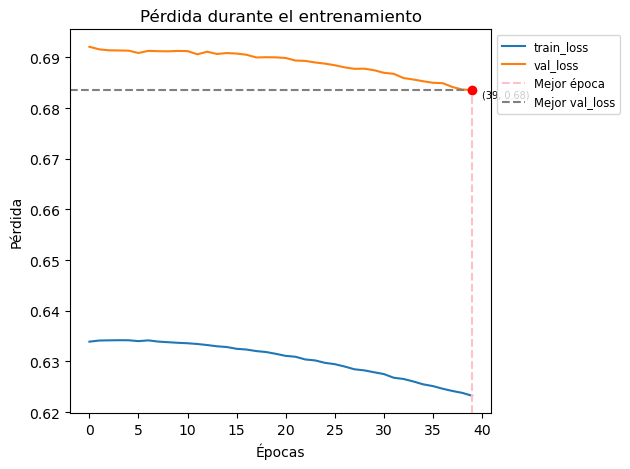

In [217]:
train_history_df = pd.DataFrame(train_history.history)

# Plotear los resultados del entrenamiento:
plt.plot(train_history_df['loss'], label='train_loss')
plt.plot(train_history_df['val_loss'], label='val_loss')

# Obtener el índice (época) del mejor valor de pérdida de validación
best_epoch = train_history_df['val_loss'].idxmin()
best_loss = train_history_df['val_loss'].min()

# Agregar líneas punteadas a la coordenada de mejores época y val_loss 
y_ratio = best_loss / plt.ylim()[1]
plt.axvline(x=best_epoch, color='pink', linestyle='--',
            ymax=(best_loss - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0]), label='Mejor época')
plt.axhline(y=best_loss, color='gray', linestyle='--', xmax=best_epoch/plt.xlim()[1], label='Mejor val_loss')
plt.plot(best_epoch, best_loss, 'ro')

# Mostrar los valores de mejor época y mejor pérdida como coordenadas
plt.text(best_epoch + 1, best_loss, f'({best_epoch}, {best_loss:.2f})',
         color='black', verticalalignment='top', horizontalalignment='left', fontsize=7)

plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()


In [218]:
# Hacer predicciones
Y_pred = lstm_model.predict(X_test)

# Invertir el escalado para obtener las predicciones en la escala original:
Y_pred_rescaled = Y_scaler.inverse_transform(Y_pred)

17115/17115 [==============================] - 32s 2ms/step


In [219]:
# Métricas de evaluación:
evaluation_metrics = lstm_model.evaluate(X_test, Y_test)

# Obtener el MAE de entrenamiento y validación al final del entrenamiento
train_mae = train_history.history['loss'][-1]
val_mae = train_history.history['val_loss'][-1]
test_mae = evaluation_metrics[0]

print("MAE entrenamiento: ", round(train_mae, 3))
print("MAE validación: ", round(val_mae, 3))
print("MAE evaluación:", round(test_mae, 3))

# Proporciones sobre entrenamiento:
print("\n")
print("Proporción MAE entrenamiento: ", round(train_mae / train_mae, 3))
print("Proporción MAE validación: ", round(val_mae / train_mae, 3))
print("Proporción MAE evaluación:", round(test_mae / train_mae, 3))

17115/17115 [==============================] - 35s 2ms/step - loss: 0.6996 - mean_squared_error: 0.9042
MAE entrenamiento:  0.623
MAE validación:  0.684
MAE evaluación: 0.7


Proporción MAE entrenamiento:  1.0
Proporción MAE validación:  1.097
Proporción MAE evaluación: 1.123


In [220]:
# Obtener el RMSE de entrenamiento y validación al final del entrenamiento
train_rmse = train_history.history['mean_squared_error'][-1]**(1/2)
val_rmse = train_history.history['val_mean_squared_error'][-1] **(1/2)
test_rmse = evaluation_metrics[1] **(1/2)

print("RMSE entrenamiento: ", round(train_rmse, 3))
print("RMSE validación: ", round(val_rmse, 3))
print("RMSE evaluación:", round(test_rmse, 3))

# Proporciones sobre entrenamiento:
print("\n")
print("Proporción RMSE entrenamiento: ", round(train_rmse / train_rmse, 3))
print("Proporción RMSE validación: ", round(val_rmse / train_rmse, 3))
print("Proporción RMSE evaluación:", round(test_rmse / train_rmse, 3))

RMSE entrenamiento:  0.838
RMSE validación:  0.942
RMSE evaluación: 0.951


Proporción RMSE entrenamiento:  1.0
Proporción RMSE validación:  1.124
Proporción RMSE evaluación: 1.135


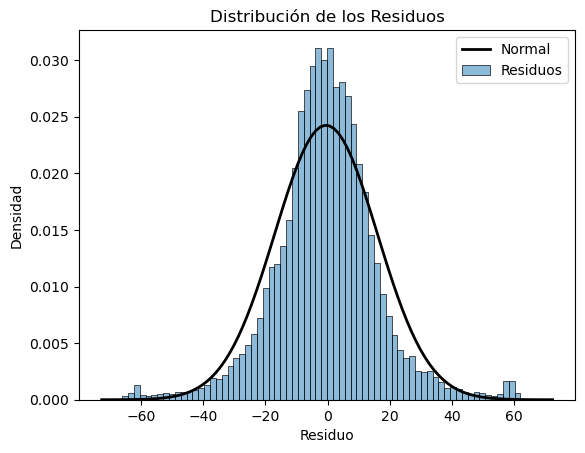

In [221]:
from scipy.stats import norm

# Calcular los residuos
resid = Y_test_rescaled - Y_pred_rescaled

# Crear un histograma de los residuos
sns.histplot(resid, kde=False, stat='density', bins=70, label='Residuos')

# Crear una curva de distribución normal con la misma media y desviación estándar
mu, std = np.mean(resid), np.std(resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal')

# Título y etiquetas
plt.title("Distribución de los Residuos")
plt.xlabel("Residuo")
plt.ylabel("Densidad")
plt.legend()
plt.show()

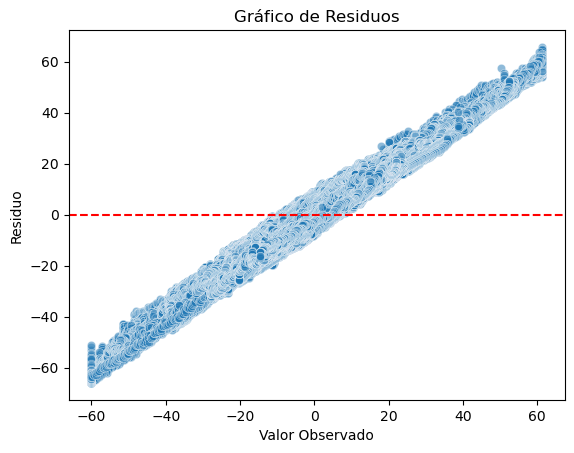

In [222]:
# Calcular los residuos
residuos = Y_test_rescaled.flatten() - Y_pred_rescaled.flatten()

# Crear un DataFrame para facilitar la visualización con Seaborn
data = pd.DataFrame({
    'Observado': Y_test_rescaled.flatten(),
    'Residuo': residuos
})

# Scatter plot de residuos
sns.scatterplot(x='Observado', y='Residuo', data=data, alpha=0.5)

# Línea horizontal en y=0 para referencia
plt.axhline(y=0, color='r', linestyle='--')

# Etiquetas y título
plt.xlabel('Valor Observado')
plt.ylabel('Residuo')
plt.title('Gráfico de Residuos')

plt.show()

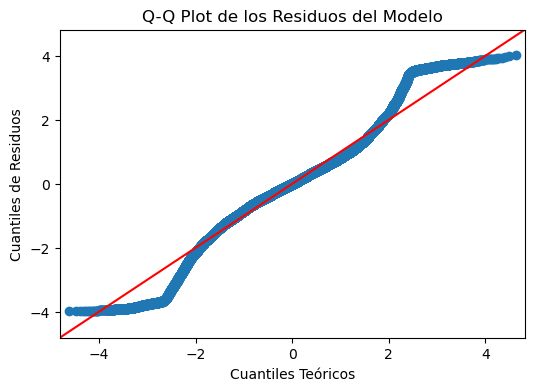

In [223]:
# Crear el Q-Q plot
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(residuos, line='45', fit=True, ax=ax)
plt.title('Q-Q Plot de los Residuos del Modelo')
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de Residuos')
plt.show()

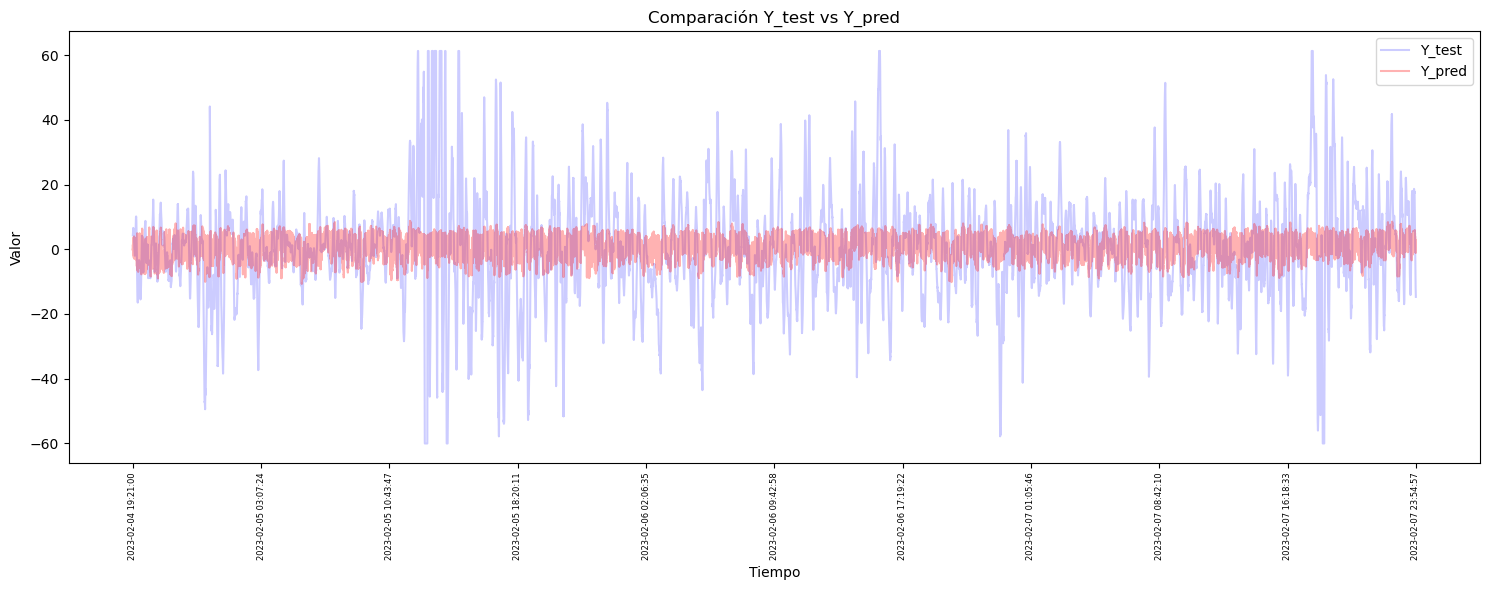

In [224]:
plt.figure(figsize=(15, 6))

# Graficar los valores reales
plt.plot(Y_test_rescaled, label='Y_test', color='blue', alpha=0.2)

# Graficar las predicciones
plt.plot(Y_pred_rescaled, label='Y_pred', color='red', alpha=0.3)

# Definir el título y las etiquetas del gráfico
plt.title('Comparación Y_test vs Y_pred')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Establecer las etiquetas del eje x usando el índice de tiempo de Y_test
time_labels = Y_test.index.to_list()
positions = list(range(0, len(Y_test_rescaled), len(Y_test_rescaled)//10))  # Tomar 10 puntos equidistantes para las etiquetas
selected_labels = [time_labels[i].strftime('%Y-%m-%d %H:%M:%S') for i in positions]
plt.xticks(positions, selected_labels, rotation=90, size=6)

plt.legend()
plt.tight_layout()
plt.show()

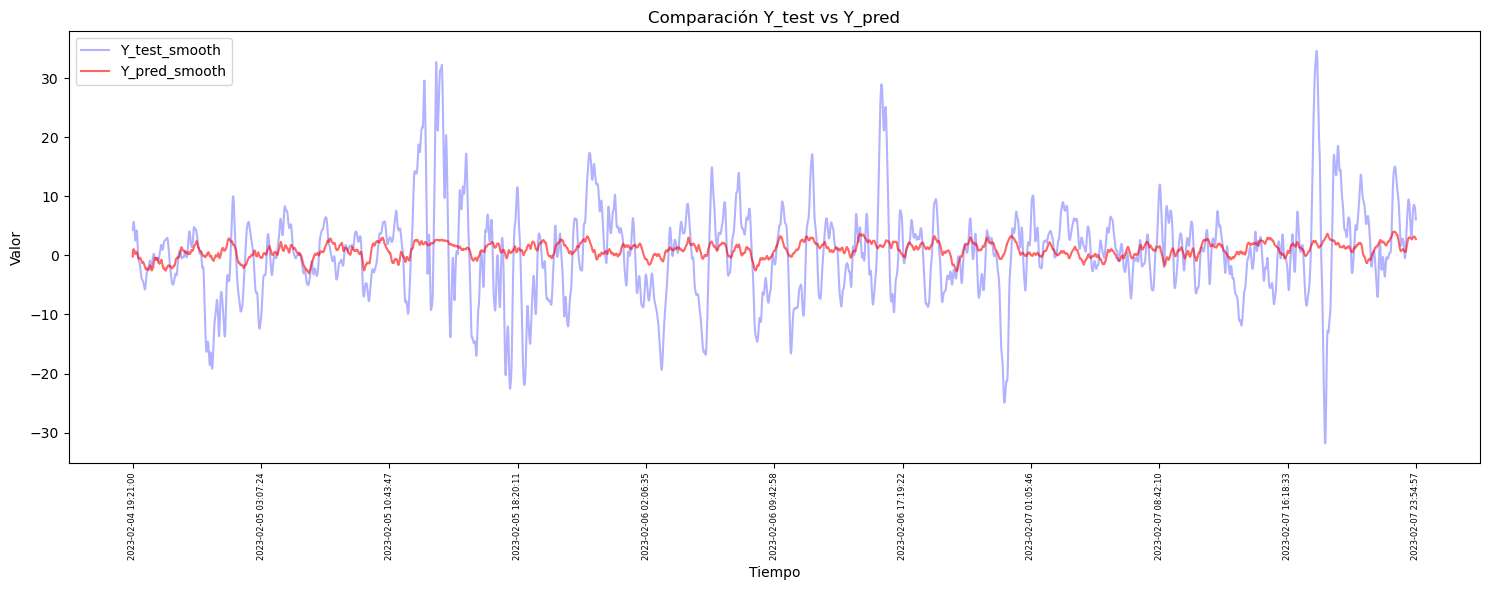

In [225]:
# Importar bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt

# Convertir Y_test_rescaled y Y_pred_rescaled a Series de Pandas para facilidad de uso
Y_test_series = pd.Series(Y_test_rescaled.flatten())
Y_pred_series = pd.Series(Y_pred_rescaled.flatten())

# Calcular la media móvil
window_size = 3600  # Ajustar según tus necesidades
Y_test_smooth = Y_test_series.rolling(window=window_size, min_periods=1).mean()
Y_pred_smooth = Y_pred_series.rolling(window=window_size, min_periods=1).mean()

# Crear el gráfico
plt.figure(figsize=(15, 6))
plt.plot(Y_test_smooth, label='Y_test_smooth', color='blue', alpha=0.3)
plt.plot(Y_pred_smooth, label='Y_pred_smooth', color='red', alpha=0.6)

# Definir el título y las etiquetas del gráfico
plt.title('Comparación Y_test vs Y_pred')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Establecer las etiquetas del eje x usando el índice de tiempo de Y_test
time_labels = Y_test.index.to_list()
positions = list(range(0, len(Y_test_rescaled), len(Y_test_rescaled)//10))  # Tomar 10 puntos equidistantes para las etiquetas
selected_labels = [time_labels[i].strftime('%Y-%m-%d %H:%M:%S') for i in positions]
plt.xticks(positions, selected_labels, rotation=90, size=6)

plt.legend()
plt.tight_layout()
plt.show()
